# TALENT Course 11
## Learning from Data: Bayesian Methods and Machine Learning
### York, UK, June 10-28, 2019 
### Christian Forssén, Chalmers University of Technology, Sweden

## Bayesian Optimization
Selected references
* Paper: [Bayesian optimization in ab initio nuclear physics](https://iopscience.iop.org/article/10.1088/1361-6471/ab2b14) by A. Ekström, C. Forssén et al., Accepted for publication in J. Phys G, (2019)
* Book: Jonas Mockus (2012). Bayesian approach to global optimization: theory and applications. Kluwer Academic.
* Software: E.g., [GPyOpt](https://sheffieldml.github.io/GPyOpt/) from Sheffield ML. 



In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import GPy
import GPyOpt

# Not really needed, but nicer plots
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

### Optimization of expensive objective functions

Let us first state an inconvenient fact about optimization:

> Global minimization is almost always intractable. In practice, we have to resort to local minimization:

For $f:\;\mathbf{R}^D \to \mathbf{R}$, with $\theta \in \Theta \subset \mathbf{R}^D$ and possibly subject to constraints $c(\theta) \leq 0$

Find point(s) $\theta_*$ for which
$$
f(\theta_*) \leq f(\theta),
$$
for all $\theta \in \Theta$ close to $\theta_*$.

Consider **expensive** objective functions, e.g.
$$
f(\theta) = \chi^2(\theta) \equiv \sum_{i=1}^N \frac{\left[ y_i^\mathrm{exp} - y_i^\mathrm{th}(\theta) \right]^2}{\sigma_i^2},
$$
where $y_i^\mathrm{th}(\theta)$ may be computationally costly to evaluate.

#### Example: Nuclear interactions from chiral EFT
Fitting a nuclear interaction with 20-30 parameters (LECs) to nucleon-nucleon scattering data and possibly few-nucleon observables.
* Each iteration requires the evaluation of ~6000 NN scattering observables (or phase shifts).
* And the solution of the A=2 and A=3-body bound-state problem with three-body forces.
* And/or various NNN scattering problems.
This is certainly an example of an expensive objective function.

Much effort has been spent on this problem by various people. Our contribution has been to:
1. introduce modern optimization technology without need for derivatives (POUNDERS in [PETSc/Tao](https://www.mcs.anl.gov/petsc/index.html)).
1. implement derivative-based minimization with first- and second-order derivatives from automatic differentiation.

#### With POUNDERS
Ekström et al, (2013)
[![An optimized chiral nucleon-nucleon interaction at next-to-next-to-leading order](fig/PhysRevLett.110.192502.png)](https://doi.org/10.1103/PhysRevLett.110.192502)

#### With POUNDERS (using scattering observables, i.e. including uncertainties)
Ekström et al., (2015)
[![Statistical uncertainties of a chiral interaction at next-to-next-to leading order](fig/JPhysG_2015.png)](https://doi.org/10.1088/0954-3899/42/3/034003)

#### Order-by-order with correlations and using Automatic differentiation
Carlsson et al., (2016)
[![Uncertainty analysis and order-by-order optimization of chiral nuclear interactions](fig/PhysRevX.6.011019.png)](https://doi.org/10.1103/PhysRevX.6.011019)

## Bayesian optimization

> An optimization algorithm for expensive black-box functions

There are two main components in this algorithm; 
1. A prior probabilistic belief $p(f|D)$ for the objective function $f(\theta)$ given some data $D$. The prior is often a Gaussian process. This is updated in every iteration.  
1. An acquisition function $\mathcal{A}(\theta|D)$ given some data $D$.  This is a heuristic that balances exploration against exploitation and determines where to evaluate the objective function $f(\theta)$ next. 

Pseudo-code for BayesOpt
1. initial $\mathbf{\theta}^{(1)},\mathbf{\theta}^{(2)},\ldots \mathbf{\theta}^{(k)}$, where $k \geq 2$
1. evaluate the objective function $f(\mathbf{\theta})$ to obtain $y^{(i)}=f(\mathbf{\theta}^{(i)})$ for $i=1,\ldots,k$
1. initialize a data vector $\mathcal{D}_k = \left\{(\mathbf{\theta}^{(i)},y^{(i)})\right\}_{i=1}^k$
1. select a statistical model for $f(\mathbf{\theta})$
1. **For** {$n=k+1,k+2,\ldots$}
   1.    select $\mathbf{\theta}^{(n)}$ by optimizing the acquisition function
   1.    $\mathbf{\theta}^{(n)} = \underset{\mathbf{\theta}}{\text{arg max}}\, \mathcal{A}(\mathbf{\theta}|\mathcal{D}_{n-1})$
   1.    evaluate the objective function to obtain $y^{(n)}=f(\mathbf{\theta}^{(n)})$
   1.    augment the data vector $\mathcal{D}_n = \left\{\mathcal{D}_{n-1} , (\mathbf{\theta}^{(n)},y^{(n)})\right\}$
   1.    update the statistical model for $f(\mathbf{\theta})$
1. **end for**


Some remarks:
* Use of a space-filling method such as LHS or Sobol for the initial $k$ evaluations.
* Use of a gaussian process, or a Gaussian emulator, for the statistical model of $f(\theta)$.
* The choice of aquisition function is the heart of BayesOpt. There are several possible choices; with different balance between exploration-exploitation.
   * Expected improvement
   * Lower confidence bound
* The update of the statistical model is an $\mathcal{O}(n^3)$ cost (if using a GP).
* The stopping criterion might be a fixed computational budget that limits the number of function evaluations that can be made.

## Univariate example

In [2]:
xmin =  0.
xmax =  1.

def Ftrue(x):
    return np.sin(4*np.pi*x) + x**4

In [3]:
np.random.seed(123)
x0 = np.random.uniform(xmin,xmax)
res = sp.optimize.minimize(Ftrue,x0)
print(res)

      fun: -0.4353887059011192
 hess_inv: array([[0.00611671]])
      jac: array([-9.68575478e-08])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.85884268])


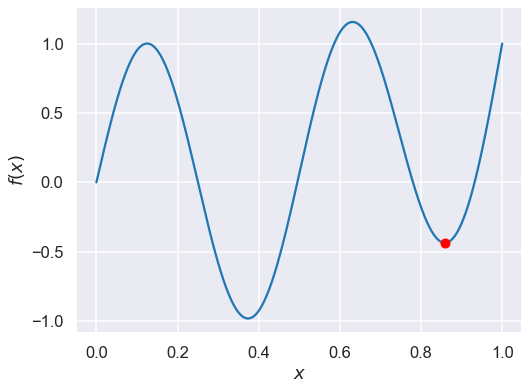

In [4]:
X_domain = np.linspace(xmin,xmax,1000)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(X_domain,Ftrue(X_domain))
ax.plot(res.x[0],res.fun,'ro')
ax.set(xlabel=r'$x$',ylabel=r'$f(x)$');

In [5]:
# parameter bound(s) 
bounds = [{'name': 'x_1', 'type': 'continuous', 'domain': (xmin,xmax)}]

In [6]:
acquisition_type = 'EI'
#acquisition_type = 'LCB'

# Creates GPyOpt object with the model and aquisition function
myBopt = GPyOpt.methods.BayesianOptimization(\
            f=Ftrue,            # function to optimize   
            initial_design_numdata=1, # Start with two initial data
            domain=bounds,        # box-constraints of the problem
            acquisition_type=acquisition_type, # Selects the acquisition type
            exact_feval = True) 

In [7]:
# Run the optimization
np.random.seed(123)
max_iter = 1     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the last two observations

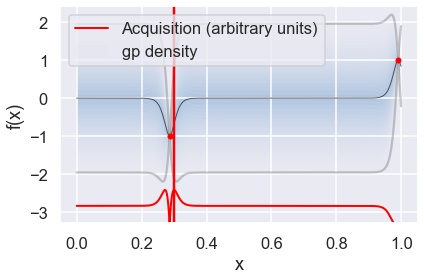

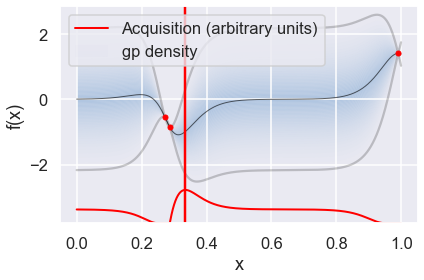

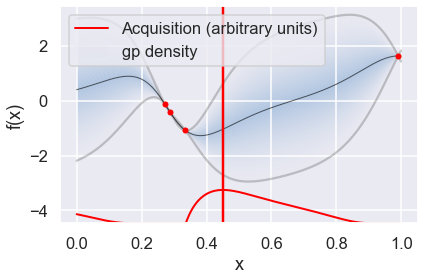

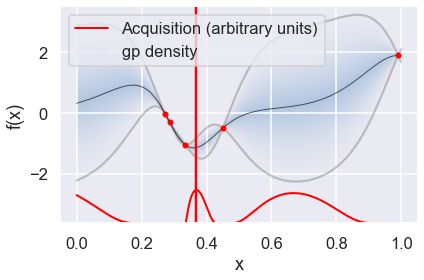

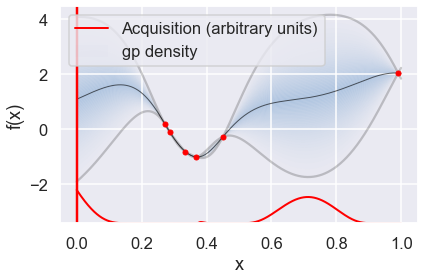

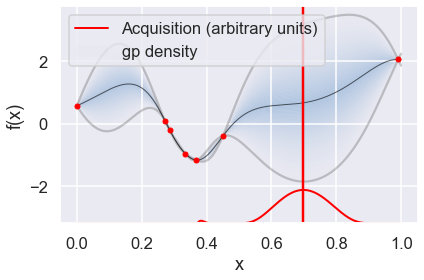

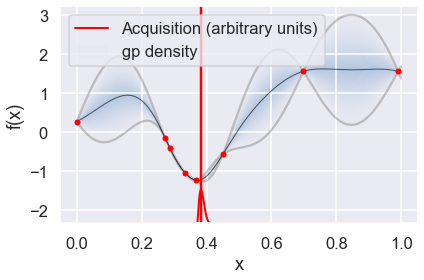

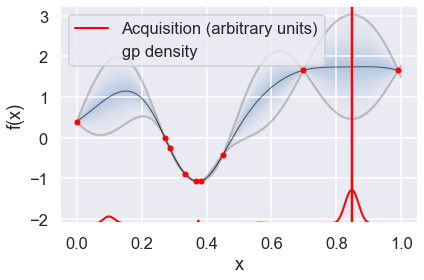

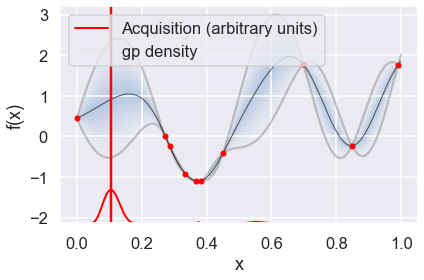

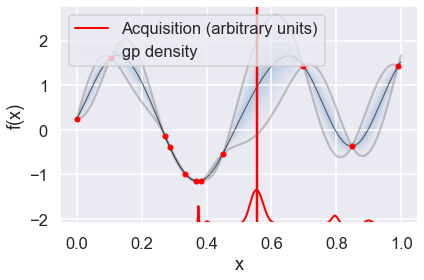

In [8]:
for i in range(10):
    myBopt.run_optimization(max_iter, max_time, eps)                     
    myBopt.plot_acquisition()

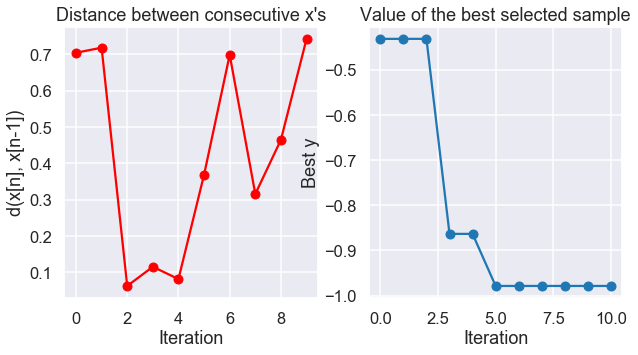

In [9]:
myBopt.plot_convergence()

## Bivariate example

Next, we try a 2-dimensional example. In this case we minimize the Six-hump camel function
$$
f(\theta_1,\theta_2)=\left( 4−2.1 \theta_1^2 + \frac{\theta_1^4}{3}\right)\theta_1^2+\theta_1 \theta_2+\left(−4+4\theta_2^2\right)\theta_2^2,
$$
in $[−3,3]$, $[−2,2]$. This functions has two global minimum, at (0.0898,−0.7126) and (−0.0898,0.7126). The function is already pre-defined in `GPyOpt`. In this case we generate observations of the function perturbed with white noise of sd=0.1.

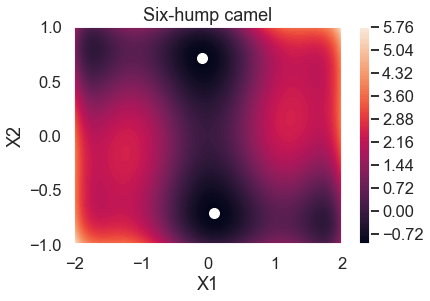

In [10]:
# create the object function
f_true = GPyOpt.objective_examples.experiments2d.sixhumpcamel()
f_sim = GPyOpt.objective_examples.experiments2d.sixhumpcamel(sd = 0.1)
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]},
         {'name': 'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]}]
f_true.plot()

In [16]:
myBopt2D = GPyOpt.methods.BayesianOptimization(f_sim.f,
                                              domain=bounds,
                                              model_type = 'GP',
                                              acquisition_type='EI',  
                                              normalize_Y = True,
                                              exact_feval = False)    

In [17]:
# runs the optimization for the three methods
max_iter = 40  # maximum time 40 iterations
max_time = 60  # maximum time 60 seconds

myBopt2D.run_optimization(max_iter,max_time,verbosity=False)            

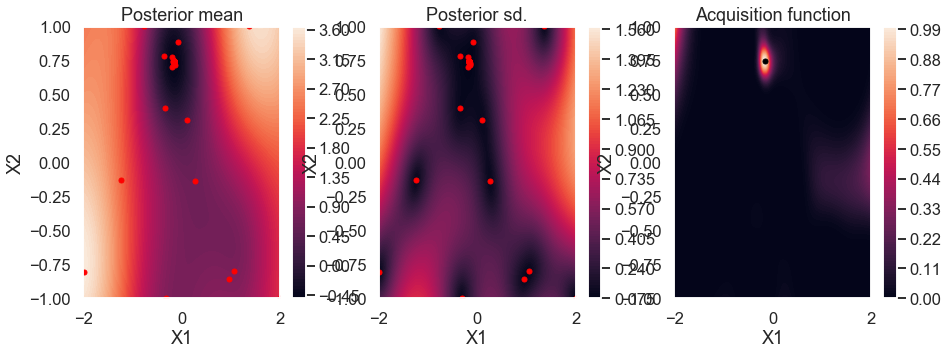

In [18]:
myBopt2D.plot_acquisition() 

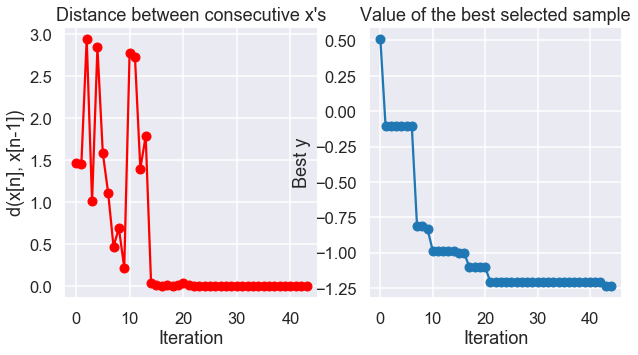

In [19]:
myBopt2D.plot_convergence()

### Space-filling sampling

![sampling](fig/space_filling_sampling.png)

* Sobol sequence sampling in Python, e.g. with [sobol_seq](https://github.com/naught101/sobol_seq)
* Latin Hypercube Sampling in Python, e.g. with [pyDOE](https://pythonhosted.org/pyDOE/index.html)
* Mersenne-Twister is the core random number generator in Python / numpy

## Some concluding remarks
from our paper [arXiv:1902.00941](https://arxiv.org/abs/1902.00941). Accepted for publication in J. Phys G, (2019)
* **Prior knowledge/belief is everything!** Important to tailor the acquisition function and the GP kernel to the spatial structure of the objective function. Thus, the usefulness of BayesOpt hinge on the arbitrariness and uncertainty of a priori information. Complicated by the fact that we resort to BayesOpt when little is known about the objective function in the first place, since it is computationally expensive to evaluate. 
* In general, BayesOpt will never find a narrow minimum **nor be useful for extracting the exact location of any optimum**. 
* We find that the **acquisition function is more important** than the form of the GP-kernel. 
* BayesOpt would probably benefit from a prior that captures the **large-scale structure of the objective function**.
* **High-dimensional parameter domains** are always challenging (subspace learning, dim reduction).